In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

/usr/bin/sh: nvidia-smi: command not found


In [2]:
# !pip install -q -U watermark
# !pip install -qq transformers
# # Update libraries
# !pip install seaborn==0.9.0
# !pip install sklearn
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                usecols= ['Tweet', 'Substance', 'Use', 'Intent']
                )
df

,Tweet,Substance,Use,Intent
0,@aaronaxline @friskycarolina was livid to watc...,X,X,X
1,anyways. im starting my diet on Sunday. i was ...,A,S,A
2,Alcohol and drugs is good for the mind but not...,D,S,A
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",X,X,X
4,Bro do you ever get in those moods where you j...,X,X,X
...,...,...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,C,S,X
4463,Ain't no salary cap in the dope game ain't no ...,C,X,X
4464,Aw man they busting out the nose candy &amp; f...,C,N,A
4465,They say crack kill nigga my crack sell #21Savage,C,X,X


In [166]:
# df =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
#                       lineterminator='\n',skipinitialspace=True, usecols= ['Tweet', 'Substance', 'Use'])
# # in the tweets find the hashtag
# df['hashTags'] = df['Tweet'].str.findall("#(\w+)")
# # in the tweets find the mentions
# df['mentions'] = df['Tweet'].str.findall("@(\w+)")

# # Remove hashtag and mentions
# df['Tweet'] = df['Tweet'].str.replace(r'#(\w+)', '', regex=True)
# df['Tweet'] = df['Tweet'].str.replace(r'@(\w+)', '', regex=True)

# # df

In [167]:
# LABEL_COLUMNS = df.columns.tolist()[1:]
# val = df[LABEL_COLUMNS].sum().sort_values()
# val

In [6]:
df = df.dropna(subset=['Substance'])

In [10]:
df.loc[df['Substance']=='CD']

,Tweet,Substance,Use,Intent
3879,"When I text a cute game, wildness Throw a stac...",CD,N,X


# Labeling Substance Column

Text(0.5, 0, 'Substance Types')

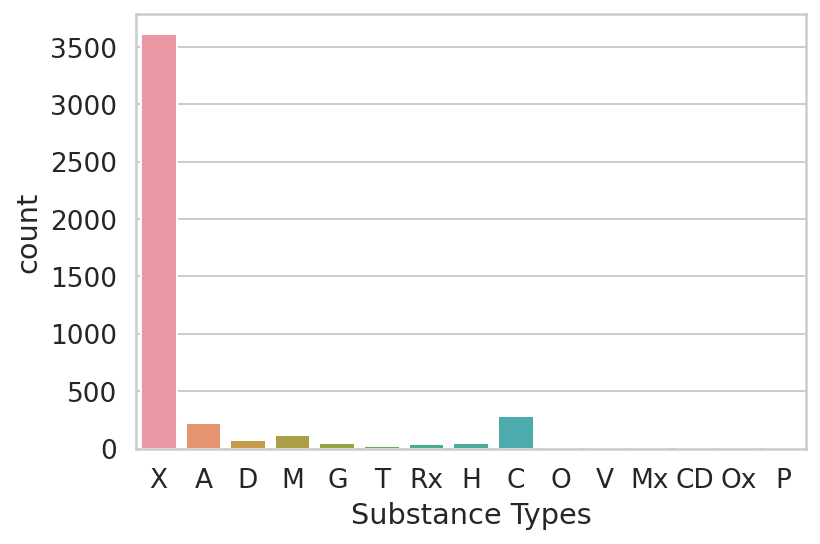

In [168]:
substance_class_names = { 'D': 'Multiple identified specific substances', 
               'A':'Alcohol',
               'M':'Marijuana',
               'T':'Tobacco',
               'V':'Vape', 
               'C':'Cocaine',
               'G':'Indeterminiate and or generic dec indicative of substance type(s)',
               'H':'Heroine',
               'Rx':'Prescription and or pharmaceutical substances used appropriately and or misused ',
               'Ox':'Non-prescription and over-the-counter substances misused or abused (Typical) ',
               'P': 'Psychedelics and hallucinogens ',
               'Mx':'Methamphetamine',
               'CD':'Club drugs',
               'O':'Other substances used for substance misuse (Atypical) ',
               'X':'Unclear'
              }
substance_possible_labels = df.Substance.unique()
substance_label_dict = {}
for index, possible_label in enumerate(substance_possible_labels):
    substance_label_dict[possible_label] = index
# for e in substance_label_dict.keys():
#     print(substance_label_dict[e], e, substance_class_names[e])
sns.countplot(df.Substance)
plt.xlabel('Substance Types')

0 X Not specific or non-specific substance use
1 S Specific information about substance use
2 N Non-specific information about substance use
3 U *****
4 H *****


Text(0.5, 0, 'Substance Use')

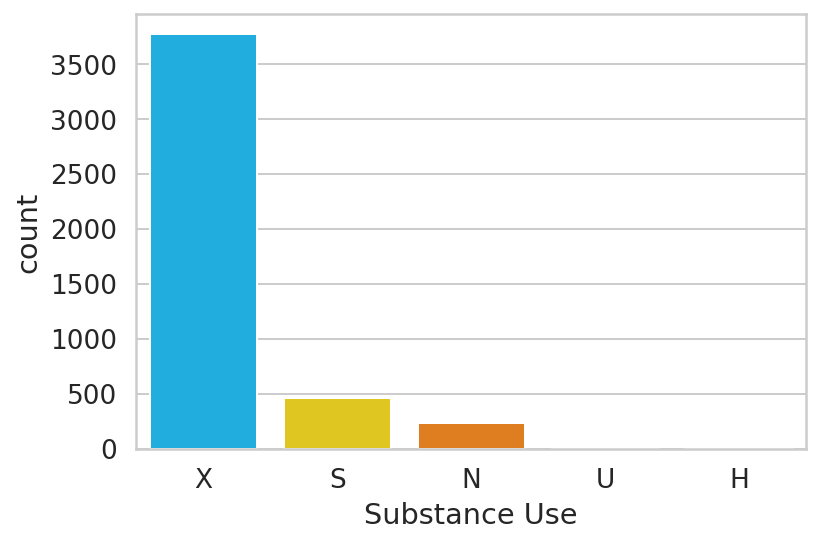

In [169]:
use_class_names = { 'S': 'Specific information about substance use', 
               'N':'Non-specific information about substance use',
               'X':'Not specific or non-specific substance use',
               'U': '*****',
               'H': '*****'
              }
use_possible_labels = df.Use.unique()

use_label_dict = {}
for index, possible_label in enumerate(use_possible_labels):
    use_label_dict[possible_label] = index
for e in use_label_dict.keys():
    print(use_label_dict[e], e, use_class_names[e])
sns.countplot(df.Use)
plt.xlabel('Substance Use')
# use_possible_labels

In [198]:
# df['Intent'] = df['Intent'].replace(np.nan, 'N')
df = df.dropna(subset=['Intent'])

0 X Not active, historical, intent
1 A Active/recent active use
2 I Intent to use
3 H Historical use
4 N ****


Text(0.5, 0, 'Substance Intent')

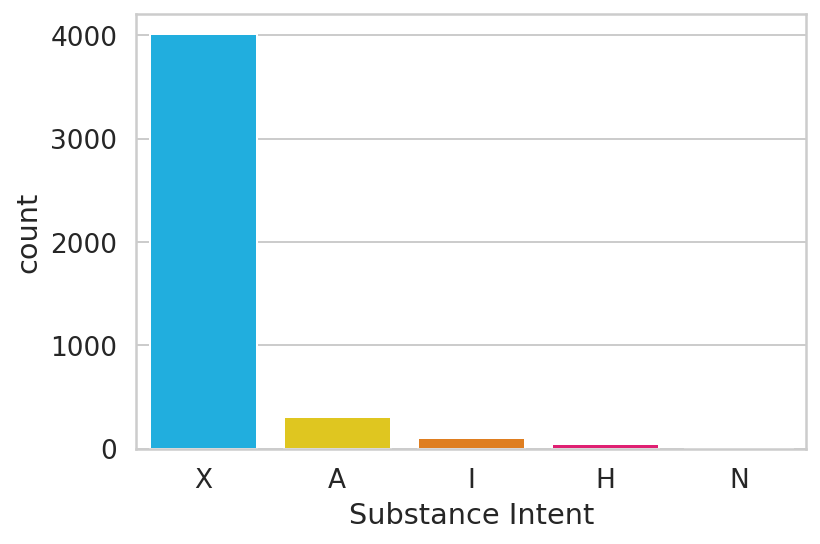

In [199]:
intent_class_names = { 'A': 'Active/recent active use', 
               'H':'Historical use',
               'I':'Intent to use',
               'X': 'Not active, historical, intent',
                'N' : '****'
              }
intent_possible_labels = df.Intent.unique()

intent_label_dict = {}
for index, possible_label in enumerate(intent_possible_labels):
    intent_label_dict[possible_label] = index
for e in intent_label_dict.keys():
    print(intent_label_dict[e], e, intent_class_names[e])
    
sns.countplot(df.Intent)
plt.xlabel('Substance Intent')


In [200]:
intent_label_dict

{'X': 0, 'A': 1, 'I': 2, 'H': 3, 'N': 4}

In [201]:
# new_df= df['Tweet']
df2= df.replace({'Substance':substance_label_dict,
                              'Use': use_label_dict,
                              'Intent':intent_label_dict })

# df['Type_label'] = df.Substance.replace(substance_label_dict)
# df['Use_label'] = df.Use.replace(use_label_dict)
# df['Intent_label'] = df.Intent.replace(intent_label_dict)
# df['Intent_label'] = df['Intent_label'].apply(np.int64)

df2.tail(10)

,Tweet,Substance,Use,Intent
4457,I know the freeway stunt was a reenactment for...,14,2,0
4458,"Ima buy a rig when I get home üòè,",7,1,2
4459,If you too drunk to drive call me or text me 3...,1,2,1
4460,"So who's drunk ass needs a ride??? Cash only (:,",1,2,0
4461,This cab driver asking us for bud and telling ...,2,1,1
4462,How much coke she did no wonder age OD'd. Damn.,8,1,0
4463,Ain't no salary cap in the dope game ain't no ...,8,0,0
4464,Aw man they busting out the nose candy &amp; f...,8,2,1
4465,They say crack kill nigga my crack sell #21Savage,8,0,0
4466,crackhead on my street tried to sell me a kid'...,8,1,1


# DATA PREPROCESSING

Text(0.5, 0, 'Token count')

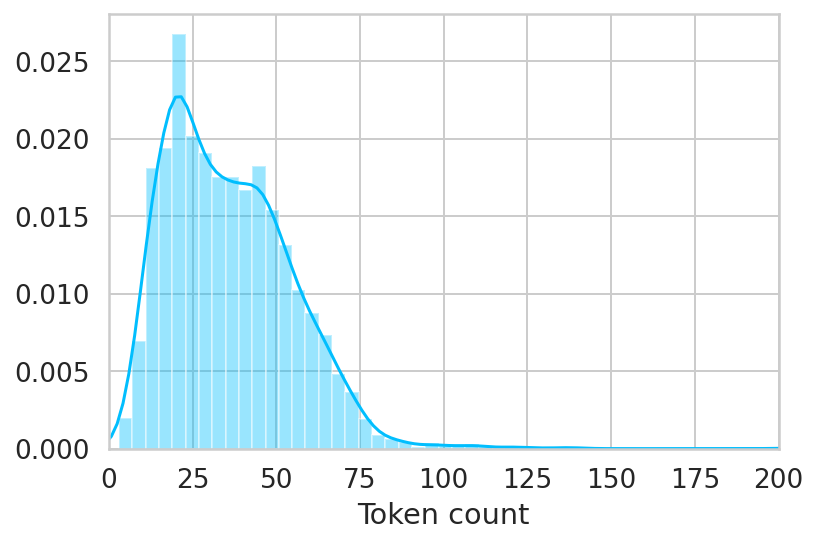

In [207]:
#choosing sequence length
token_lens = []
for txt in df.Tweet:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')

# MAX_LEN = 80

In [202]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/TokRoBERTa_april21'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [249]:
LABEL_COLUMNS   = ['Substance', 'Use', 'Intent']
sample_text = df2.iloc[4463]['Tweet']
labels = df2.iloc[4463][LABEL_COLUMNS]
# sample_text = 'This is awesome. We are almost there!'
tokens = tokenizer.encode_plus(
            sample_text,
            None,
            max_length= MAX_LEN,
            truncation=True,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
print(f' Sentence: {sample_text}')
print(f' Tokens: {tokens}')
print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
print(f' Tokens.input_ids: {len(tokens.input_ids)}')

output = {
      'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

output


 Sentence: Aw man they busting out the nose candy &amp; feeding them what looks like more organs #AHSRoanoke #AHS6
 Tokens: {'input_ids': [0, 37, 91, 603, 495, 279, 4037, 533, 284, 505, 392, 304, 3032, 525, 468, 31, 5713, 282, 725, 504, 1663, 467, 590, 7983, 524, 332, 37, 44, 55, 54, 83, 277, 2084, 332, 37, 44, 55, 26, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'att

{'input_ids': tensor([   0,   37,   91,  603,  495,  279, 4037,  533,  284,  505,  392,  304,
         3032,  525,  468,   31, 5713,  282,  725,  504, 1663,  467,  590, 7983,
          524,  332,   37,   44,   55,   54,   83,  277, 2084,  332,   37,   44,
           55,   26,    2,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1

In [250]:
df2.iloc[4463][LABEL_COLUMNS]

Substance    8
Use          2
Intent       1
Name: 4464, dtype: object

In [254]:
from torch.utils.data import Dataset
LABEL_COLUMNS   = ['Substance', 'Use', 'Intent']

class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row[LABEL_COLUMNS]
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
#                                      padding=MAX_LEN,
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [255]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4019, 4), (223, 4), (224, 4))

In [256]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

In [257]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [262]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['token_type_ids'].shape)
print(data['targets'].shape)

# ds = Tweet_DataSet(df2,tokenizer=tokenizer,max_len=MAX_LEN)
# ds[0]

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 3])


In [264]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging


class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [267]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, len(label_dict))
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able

In [34]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# token_type_ids = data['token_type_ids'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length
# print(token_type_ids) # batch size x seq length

# import torch.nn.functional as F
# # To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:
# F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

In [268]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [269]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [96]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [270]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):


#   modelPath = "/content/best_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/16
----------


RuntimeError: The size of tensor a (16) must match the size of tensor b (3) at non-singleton dimension 1

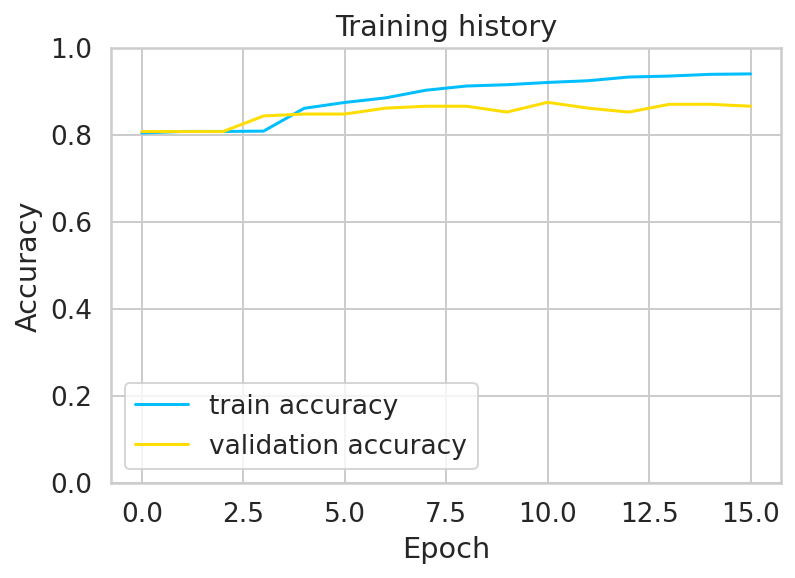

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8928571428571428

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [43]:
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [59]:
y_review_texts,y_pred_probs, y_pred, y_test

(["  yea it's called crack",
  " if I can't make a joke about blue balls then conservative old men shouldn't write laws about peoples' uteri. ",
  'Save a horse, ride a cowboy',
  ' I sent screenshots. ;)',
  "Out being high-octane basic with the love of my life  @ Quattro Goomba's Winery https://t.co/bsnLnKiXbD",
  'Fuck you and your heroin jokes',
  'a never ending debate: should i drink the wine or not',
  '        Thanks Tez!',
  'First round of Halloween parties starts tonight. Lets get lit people. Party scene been dead for too long, lets get it poppin',
  ' Rocky Mountain Milky Way',
  'YES OMFG😂😂😂😂   https://t.co/kPQKSKepzn',
  ' New Show ON   ://t.co/P2zEeZpFaU',
  'Gov: "The bottom line is that I promised to make education a priority and do my best to protect it from budget cuts, and I kept my promise."',
  'I wish it was summer and I was sitting creek side smoking a j next to someone I loved.',
  'This motherfucker did bumps ',
  'Some shots from my shoot for F.I.T. Studio. C

In [61]:
a = y_test.numpy

In [62]:
someListOfLists = list(zip(y_review_texts, y_test, y_pred, y_pred_probs ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob'])
# dff['Real']= pd.to_numeric(df["Real"])
dff

,tweet,Real,Predicted,Pred-prob
0,yea it's called crack,tensor(8),tensor(8),"[tensor(0.0533), tensor(0.0213), tensor(0.0407..."
1,if I can't make a joke about blue balls then ...,tensor(0),tensor(0),"[tensor(0.9964), tensor(0.0022), tensor(6.4644..."
2,"Save a horse, ride a cowboy",tensor(0),tensor(8),"[tensor(0.0163), tensor(0.0118), tensor(0.0346..."
3,I sent screenshots. ;),tensor(0),tensor(0),"[tensor(0.9966), tensor(0.0022), tensor(6.4313..."
4,Out being high-octane basic with the love of m...,tensor(1),tensor(3),"[tensor(0.0110), tensor(0.0051), tensor(0.0338..."
...,...,...,...,...
219,otherwise you look shallow and mean.,tensor(0),tensor(0),"[tensor(0.9969), tensor(0.0018), tensor(6.2395..."
220,Cleared: Incident on SB from Rosedale Avenue;...,tensor(0),tensor(0),"[tensor(0.9966), tensor(0.0021), tensor(6.5586..."
221,One of these days I'm actually gonna do cocaine.,tensor(8),tensor(8),"[tensor(0.0158), tensor(0.0114), tensor(0.0341..."
222,assembly. Photo creds: ambersuephotography @...,tensor(0),tensor(0),"[tensor(0.9963), tensor(0.0024), tensor(6.7498..."


In [63]:
# class_names, label_dict, possible_labels
# label_dict.keys()
# y_pred


possible_labels_test = df_test.Substance.unique()
possible_labels_test
# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index
# label_dict

array(['C', 'X', 'A', 'H', 'G', 'M', 'D', 'Rx'], dtype=object)

In [64]:
print(classification_report(y_test, y_pred, target_names=possible_labels_test))

ValueError: Number of classes, 9, does not match size of target_names, 8. Try specifying the labels parameter

In [53]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=possible_labels_test, columns=possible_labels_test)
show_confusion_matrix(df_cm)

ValueError: Shape of passed values is (9, 9), indices imply (8, 8)

In [54]:
idx = 15
idx = 99

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': possible_labels,
  'values': y_pred_probs[idx]
})
true_sentiment, y_pred[idx]

(tensor(8), tensor(8))

In [55]:
pred_df

,class_names,values
0,X,0.013726
1,A,0.010969
2,D,0.033471
3,M,0.001005
4,G,0.000310
5,T,0.000332
6,Rx,0.000432
7,H,0.000598
8,C,0.937124
9,O,0.000234


In [ ]:
# possible_labels,class_names,true_sentiment

In [56]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {possible_labels[true_sentiment]}')
print(f'True sentiment category fullname: {class_names[possible_labels[true_sentiment]]}')

In a cab &amp; the girls next to me snorting cocaine...I like this
cab.

True sentiment: C
True sentiment category fullname: Cocaine


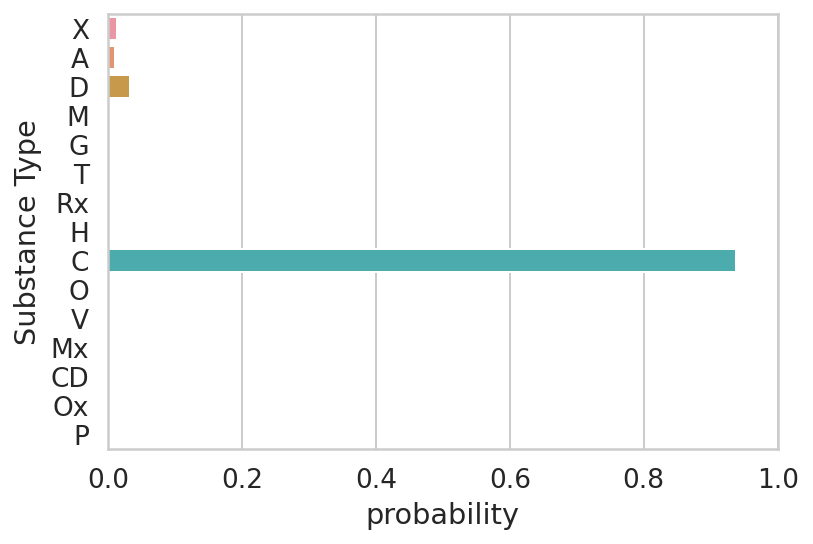

In [57]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Substance Type')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on Raw Text

In [263]:
tweet = "Some shots from my shoot for F.I.T. Studio. Coach Fred"
encoded_tweet = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
#   pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)


output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)
print(f'Tweet text: {tweet}')
print(f'Substance type  : {possible_labels[prediction]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tweet text: Some shots from my shoot for F.I.T. Studio. Coach Fred
Substance type  : O
